# 光流估计

# 1. 光流估计

① 光流是空间运动物体在观测成像平面上的像素运动的 "瞬时速度"，根据各个像素点的速度矢量特征，可以对图像进行动态分析，例如目标跟踪。

 - 亮度恒定：同一点随着时间的变化，其亮度不会发生改变。
 - 小运动：随着时间的变化不会引起位置的剧烈变化，只有小运动情况下才能用前后帧之间单位位置变化引起的灰度变化去近似灰度对位置的偏导数。
 - 空间一致：一个场景上邻近的点投影到图像上也是邻近点，且邻近点速度一致。因为光流法基本方程约束只有一个，而要求x，y方向的速度，有两个未知变量。所以需要连立n多个方程求解。

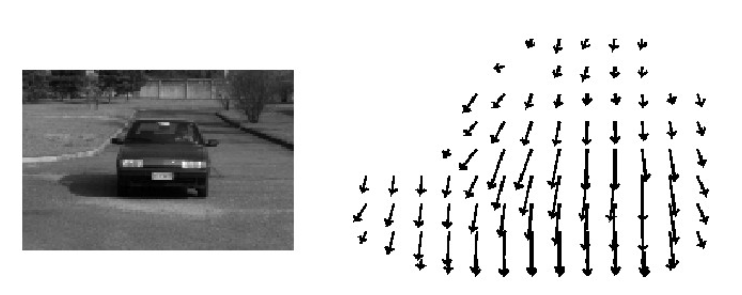

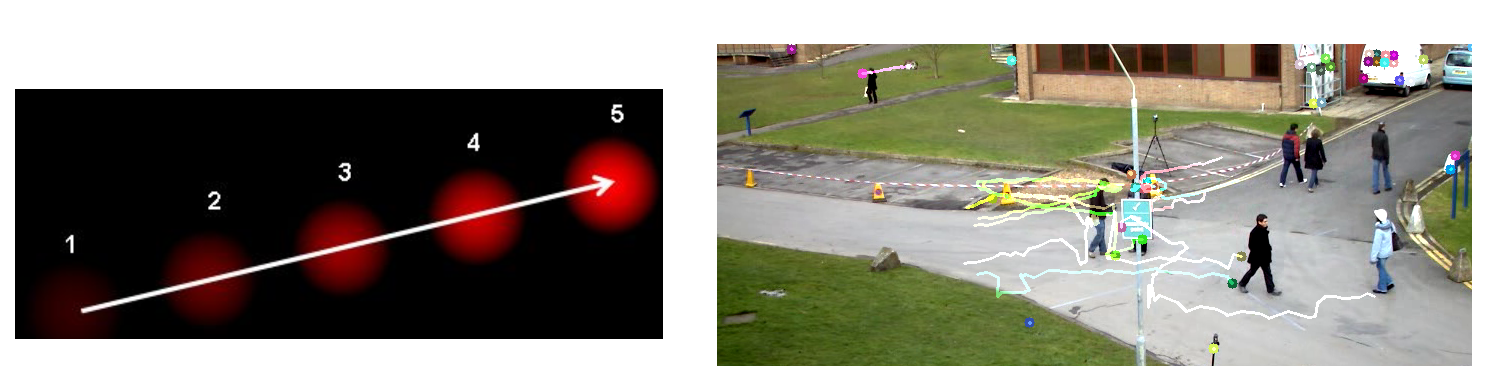

# 2. Lucas-Kanade 算法

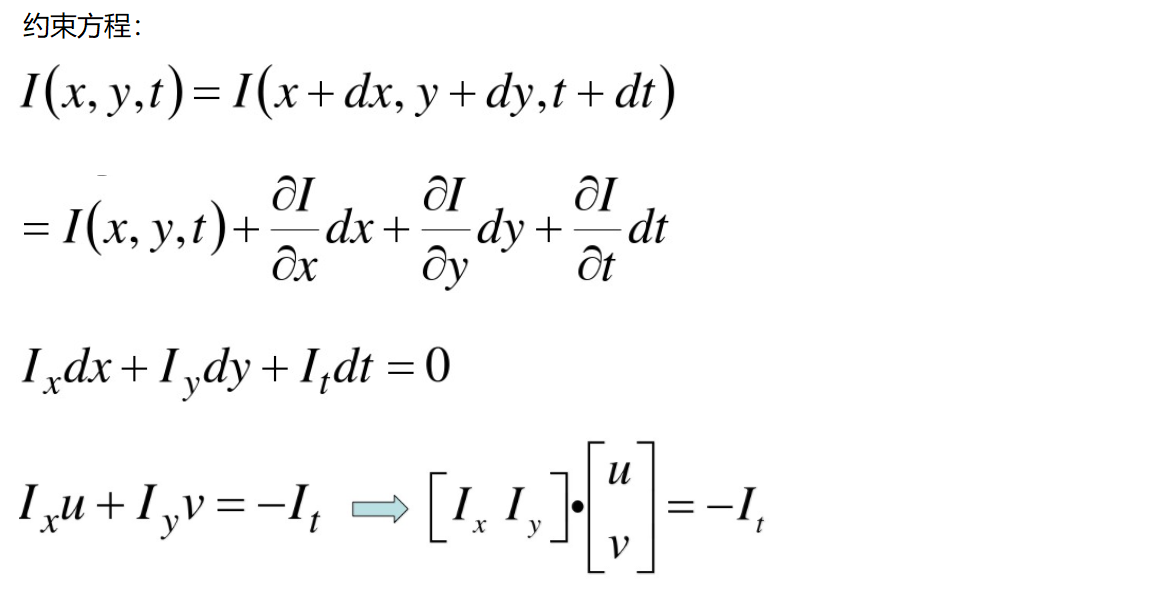

① 如何求解方程组呢？看起来一个像素点根本不够，在物体移动过程中还有哪些特性呢？

② 光流估计中需要让 $A^TA$ 可逆，那么需要让 $A^TA$ 的两个特征值比较大，才可逆。

③ 若让 $A^TA$ 的两个特征值比较大，则需要进行角点检测，角点的特征值比较大。

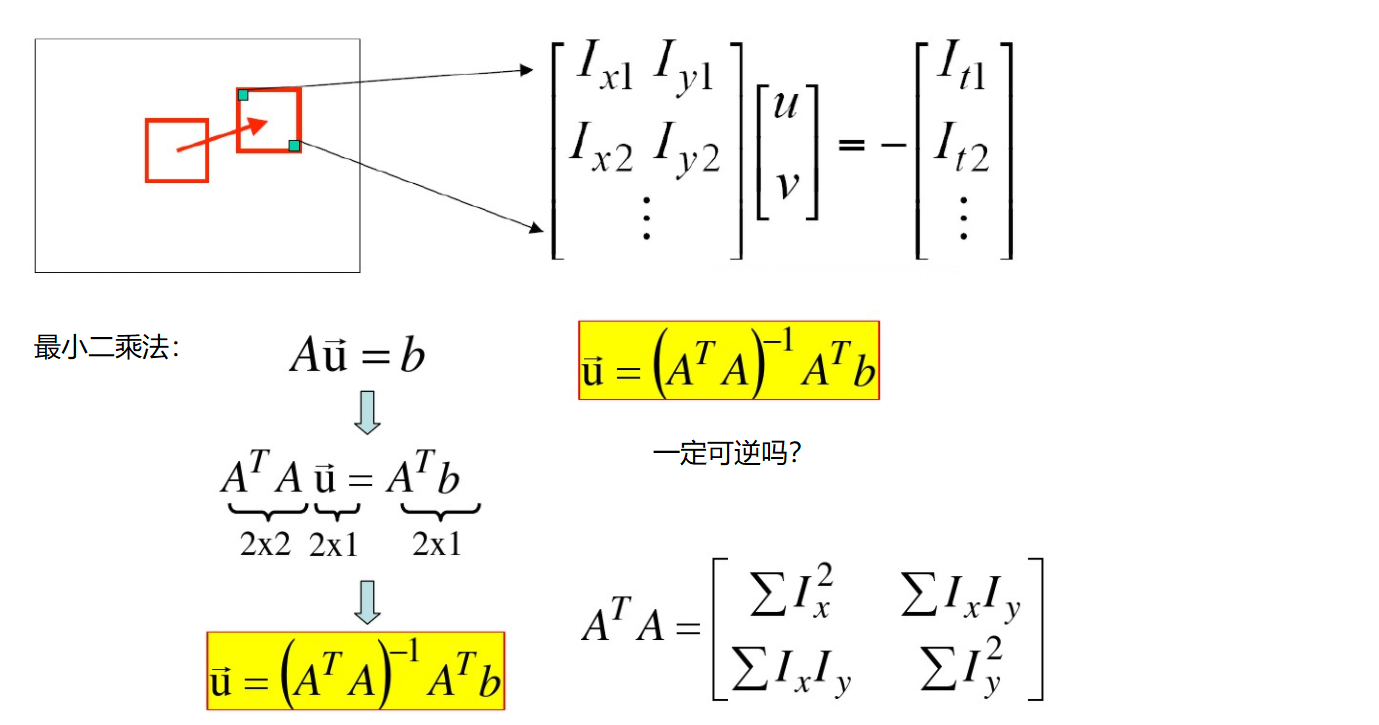

④ 光流估计函数：cv2.calcOpticalFlowPyrLK():
    
参数：
 - prevImage 前一帧图像
 - nextImage 当前帧图像
 - prevPts 待跟踪的特征点向量
 - winSize 搜索窗口的大小
 - maxLevel 最大的金字塔层数

返回：
 - nextPts 输出跟踪特征点向量
 - status 特征点是否找到，找到的状态为1，未找到的状态为0

In [1]:
import numpy as np
import cv2

cap = cv2.VideoCapture('02_Video/01_Foreground.avi')

# 角点检测所需参数
# 如果不限制角点最大数量，速度就会有些慢，达不到实时的效果
# 品质因子会筛选角点，品质因子设置的越大，得到的角点越少                
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7 )

# lucas-kanada参数
# winSize：窗口大小 maxLevel：金字塔层数
lk_params = dict( winSize = (15,15), 
                  maxLevel = 2 )

# 随即颜色条
color = np.random.randint(0,255,(100,3))

# 拿到第一帧图像
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)                         

# cv2.goodFeaturesToTrack函数返回所有检测特征点，需要输入：图像，角点最大数量(效率)，品质因子(特征值越大的越好来筛选)                                  
# 距离相当于这区间有比这个角点强的，就不要这个弱的了
# **变量 作为传入参数，是用来传入不定长的变量
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)  # 拿到第一帧的角点，后面视频中是对第一帧的角点进行追踪     

# 创建一个 mask
mask = np.zeros_like(old_frame)

while(True):
    ret, frame = cap.read()
    frame_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)                       
    
    # 需要传入前一帧和当前图像以及前一帧检测到的角点
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)                         
    
    # st=1 表示
    good_new = p1[st==1]  # st==1 表示找到的特征点，没找到的特征点就不要了
    good_old = p0[st==1]
    
    for i, (new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask,(a,b),(c,d),color[i].tolist(),2)                         
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)    
    img = cv2.add(frame,mask)
    
    cv2.imshow('frame',img)
    k = cv2.waitKey(150) & 0xff
    if k == 27:
        break
        
    # 更新
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
    
cv2.destroyAllWindows()
cap.release()